# Face Mask Detection Project


Project Goal: Detect face mask with different algorithms

Group Member: Haoran Jia, Shukai Yin, Xinghao Dong

### Resources: 
https://github.com/chandrikadeb7/Face-Mask-Detection

https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

https://github.com/MINED30/Face_Mask_Detection_YOLO

## Data preparation

In [ ]:
# Import images and annotations from github
!git clone https://github.com/K0EKJE/Face_mask_dataset.git

Cloning into 'Face_mask_dataset'...
remote: Enumerating objects: 1738, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 1738 (delta 9), reused 0 (delta 0), pack-reused 1705
Receiving objects: 100% (1738/1738), 396.42 MiB | 29.48 MiB/s, done.
Resolving deltas: 100% (850/850), done.
Updating files: 100% (1708/1708), done.


In [ ]:
# Import packages that will be used
from google.colab import drive

import os
import pandas as pd
import numpy as np
import cv2
import glob
from PIL import Image

import shutil
from pathlib import Path

from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten, Dense, Dropout
from keras import Sequential
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
!pip install Keras-Preprocessing
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns
import glob
from xml.etree import ElementTree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.5 MB/s eta 0:00:00


In [ ]:
# Defining paths
BASE_PATH = "/content/Face_mask_dataset"
XML_PATH = os.path.join(BASE_PATH, "annotations")
IMG_PATH = os.path.join(BASE_PATH, "images")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]
IMG_FILES = [os.path.join(IMG_PATH, f) for f in os.listdir(IMG_PATH)]

In [ ]:
def data_import(XML_FILES):
  '''
  Create a pandas dataframe with information of each bounding box

  input: input a list of xml path, return the pandas dataframe 
  '''

  information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}

  # Import information and labels of bound boxes
  for annotation in XML_FILES:
    tree = ElementTree.parse(annotation)                      
    
    for element in tree.iter():      
      if 'size' in element.tag:    
        for attribute in list(element): 
          if 'width' in attribute.tag: 
            width = int(round(float(attribute.text)))
          if 'height' in attribute.tag:
            height = int(round(float(attribute.text)))    

      if 'object' in element.tag:
        for attribute in list(element):
                
          if 'name' in attribute.tag:
            name = attribute.text                 
            information['label'] += [name]
            information['width'] += [width]
            information['height'] += [height] 
            information['file'] += [annotation.split('/')[-1][0:-4]] 
                            
          if 'bndbox' in attribute.tag:
            for dimension in list(attribute):
              if 'xmin' in dimension.tag:
                xmin = int(round(float(dimension.text)))
                information['xmin'] += [xmin]
              if 'ymin' in dimension.tag:
                ymin = int(round(float(dimension.text)))
                information['ymin'] += [ymin]                                
              if 'xmax' in dimension.tag:
                xmax = int(round(float(dimension.text)))
                information['xmax'] += [xmax]                                
              if 'ymax' in dimension.tag:
                ymax = int(round(float(dimension.text)))
                information['ymax'] += [ymax]
  
  # Create the pandas dataframe
  annotations_info_df = pd.DataFrame(information)

  # Add Annotation and Image File Names
  annotations_info_df['annotation_file'] = annotations_info_df['file'] + '.xml'
  annotations_info_df['image_file'] = annotations_info_df['file'] + '.png'

  # Tidy Grammatical Issue
  annotations_info_df.loc[annotations_info_df['label'] == 'mask_weared_incorrect', 'label'] = 'mask_incorrectly_worn'

  return annotations_info_df



def render_image(image_path, annotations_info_df):
    '''
    Display the image with bounding boxes

    input: input an image, return image with bounding box
    '''
    
    # Read images
    image = cv2.imread(image_path)  
    img=image_path.split('/')[-1]
    #print(image.shape)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    bound_box=[]
    
    # Draw the bound boxes on images
    for i in annotations_info_df[annotations_info_df['image_file']==img].index:
      (xmin,ymin,xmax,ymax)=(annotations_info_df.loc[i].xmin,annotations_info_df.loc[i].ymin,
                 annotations_info_df.loc[i].xmax,annotations_info_df.loc[i].ymax)
      bound_box.append((xmin,ymin,xmax,ymax))  
        
        
      if annotations_info_df.loc[i].label=='with_mask':
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0, 200, 0), 2)
        cv2.putText(image, org = (xmin - 8 , ymin - 8), text = "Mask", 
              fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, 
              color = (0, 200, 0))
      elif annotations_info_df.loc[i].label=='mask_incorrectly_worn':
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (255, 255, 0), 2)
        cv2.putText(image, org = (xmin - 8, ymin - 3), text = 'Incorrect', 
              fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, 
              color = (255, 255, 0))
      else:
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (200, 0, 0), 2)
        cv2.putText(image, org = (xmin - 8, ymin - 3), text = 'No mask', 
              fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, 
              color = (200, 0, 0))
    
    # Display images with bound boxes
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()
    
    return bound_box,image

In [ ]:
# Display the dataframe storing information of bound boxes and file names
annotations_info_df = data_import(XML_FILES)
annotations_info_df.head(10)

xmin  ymin  xmax  ymax         label             file  width  height  \
0   144   110   244   235     with_mask  maksssksksss142    479     359   
1    75   107   126   185     with_mask  maksssksksss593    400     226   
2   122    78   183   141     with_mask  maksssksksss593    400     226   
3   196    98   235   148     with_mask  maksssksksss593    400     226   
4   291    54   352   113     with_mask  maksssksksss812    400     400   
5   165   115   213   165     with_mask  maksssksksss812    400     400   
6    66    91   115   136     with_mask  maksssksksss812    400     400   
7   123   227   190   328  without_mask  maksssksksss161    301     400   
8    62   213   166   319     with_mask  maksssksksss332    301     400   
9    15   101    23   111     with_mask   maksssksksss89    400     217   

       annotation_file           image_file  
0  maksssksksss142.xml  maksssksksss142.png  
1  maksssksksss593.xml  maksssksksss593.png  
2  maksssksksss593.xml  maksssksksss593.png  
3  maksssksksss593.xml  maksssksksss593.png  
4  maksssksksss812.xml  maksssksksss812.png  
5  maksssksksss812.xml  maksssksksss812.png  
6  maksssksksss812.xml  maksssksksss812.png  
7  maksssksksss161.xml  maksssksksss161.png  
8  maksssksksss332.xml  maksssksksss332.png  
9   maksssksksss89.xml   maksssksksss89.png

In [ ]:
# Select images with 2 bound boxes
images_with_2=[]
for _ in annotations_info_df['image_file'].value_counts().index:
    if annotations_info_df[annotations_info_df['image_file']==_].shape[0]==2:
        images_with_2.append(_)
len(images_with_2)

100

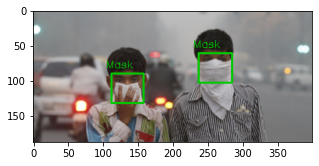

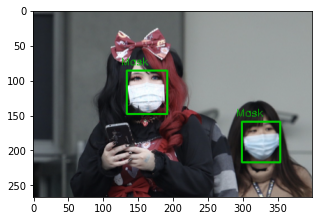

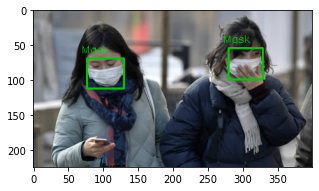

In [ ]:
# Display the first three images with 2 bound boxes
for i in images_with_2[:3]:
    render_image(os.path.join(IMG_PATH,i),annotations_info_df)

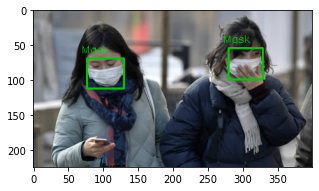

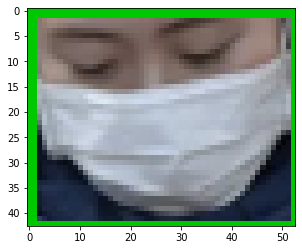

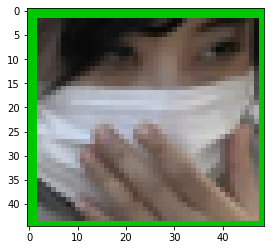

In [ ]:
# Display the cropped images
bound_box,image=render_image(os.path.join(IMG_PATH,i),annotations_info_df)
for i in bound_box:
    cropped = image[i[1]:i[3],i[0]:i[2]]
    plt.imshow(cropped)
    plt.show()

In [ ]:
# Display the number of classes
classes=annotations_info_df['label'].unique()
print(classes)

['with_mask' 'without_mask' 'mask_incorrectly_worn']


## VGG19 and ResNet50

### Data Preprocessing

In [ ]:
# Create a path storing cropped images
os.mkdir(os.path.join('/content/Face_mask_dataset', 'cropped_images'))

In [ ]:
def image_crop(annotations_info_df):
  '''
  Crop each image and create new image for each bounding box

  input: input a pandas dataframe, return a pandas dataframe with cropped image file name
  '''

  annotations_info_df['cropped_image_file'] = annotations_info_df['file']
  
  for i in range(len(annotations_info_df)):
    # Get The File Path and Read The Image
    image_filepath = os.path.join('/content/Face_mask_dataset/images', annotations_info_df['image_file'].iloc[i])
    image = cv2.imread(image_filepath)
    
    # Set The Cropped Image File Name
    annotations_info_df['cropped_image_file'].iloc[i] = annotations_info_df['cropped_image_file'].iloc[i] + '-' + str(i) + '.png'
    cropped_image_filename = annotations_info_df['cropped_image_file'].iloc[i]
    
    # Get The xmin, ymin, xmax, ymax Value (Bounding Box) to Crop Image
    xmin = annotations_info_df['xmin'].iloc[i]
    ymin = annotations_info_df['ymin'].iloc[i]
    xmax = annotations_info_df['xmax'].iloc[i]
    ymax = annotations_info_df['ymax'].iloc[i]

    # Crop The Image Based on The Values Above
    cropped_image = image[ymin:ymax, xmin:xmax]

    # if cropped_image.size >100:
    cropped_image_directory = os.path.join('/content/Face_mask_dataset/cropped_images', cropped_image_filename) 
    cv2.imwrite(cropped_image_directory, cropped_image)
  
  return annotations_info_df



In [ ]:
# Crop and display the new dataframe with file names of cropped images
annotations_info_df = image_crop(annotations_info_df)
annotations_info_df.head(10)

/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


xmin  ymin  xmax  ymax         label             file  width  height  \
0   144   110   244   235     with_mask  maksssksksss142    479     359   
1    75   107   126   185     with_mask  maksssksksss593    400     226   
2   122    78   183   141     with_mask  maksssksksss593    400     226   
3   196    98   235   148     with_mask  maksssksksss593    400     226   
4   291    54   352   113     with_mask  maksssksksss812    400     400   
5   165   115   213   165     with_mask  maksssksksss812    400     400   
6    66    91   115   136     with_mask  maksssksksss812    400     400   
7   123   227   190   328  without_mask  maksssksksss161    301     400   
8    62   213   166   319     with_mask  maksssksksss332    301     400   
9    15   101    23   111     with_mask   maksssksksss89    400     217   

       annotation_file           image_file     cropped_image_file  
0  maksssksksss142.xml  maksssksksss142.png  maksssksksss142-0.png  
1  maksssksksss593.xml  maksssksksss593.png  maksssksksss593-1.png  
2  maksssksksss593.xml  maksssksksss593.png  maksssksksss593-2.png  
3  maksssksksss593.xml  maksssksksss593.png  maksssksksss593-3.png  
4  maksssksksss812.xml  maksssksksss812.png  maksssksksss812-4.png  
5  maksssksksss812.xml  maksssksksss812.png  maksssksksss812-5.png  
6  maksssksksss812.xml  maksssksksss812.png  maksssksksss812-6.png  
7  maksssksksss161.xml  maksssksksss161.png  maksssksksss161-7.png  
8  maksssksksss332.xml  maksssksksss332.png  maksssksksss332-8.png  
9   maksssksksss89.xml   maksssksksss89.png   maksssksksss89-9.png

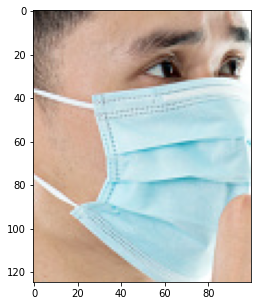

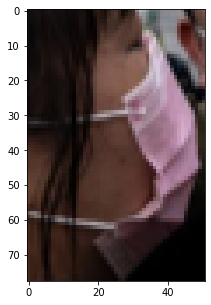

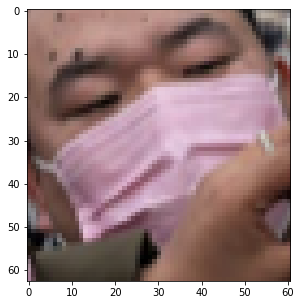

In [ ]:
# Test we successfully crop the images
for i in annotations_info_df['cropped_image_file'][:3]: 
  render_image(os.path.join('/content/Face_mask_dataset/cropped_images',i),annotations_info_df)

In [ ]:
# Train test (validation here) split
labels=annotations_info_df['label']
X_train,X_test,Y_train,Y_test=train_test_split(annotations_info_df,labels,test_size=0.25,stratify=labels,random_state=42)

In [ ]:
# Generate train set and validation set
image_target_size = (int(60), int(60))
train_image_generator = ImageDataGenerator(rescale = 1. / 255.)
val_image_generator = ImageDataGenerator(rescale = 1. / 255.)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_train,
    directory = '/content/Face_mask_dataset/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    subset = 'training',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)
val_generator = val_image_generator.flow_from_dataframe(
    dataframe = X_test,
    directory = '/content/Face_mask_dataset/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)
val_generator.class_indices

Found 3054 validated image filenames belonging to 3 classes.
Found 1018 validated image filenames belonging to 3 classes.


{'mask_incorrectly_worn': 0, 'with_mask': 1, 'without_mask': 2}

### Loading and Building VGG19 and ResNet50V2

In [ ]:
# Import VGG19 model
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(60,60,3))

for layer in vgg19.layers:
    layer.trainable = False

# Build model    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                         

In [ ]:
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input

# Import Resnet model
ResNet50 = ResNet50V2(weights='imagenet',include_top=False,input_shape=(60,60,3))

for layer in ResNet50.layers:
    layer.trainable = False

# Build model    
model2 = Sequential()
model2.add(ResNet50)
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(3,activation='softmax'))
model2.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                524352    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                       

### Training

In [ ]:
# Train the model
model.compile(loss = 'categorical_crossentropy',
       optimizer = keras.optimizers.Adam(learning_rate=0.0005),
       metrics = ['accuracy'])

history = model.fit(train_generator, epochs = 50, steps_per_epoch = len(train_generator),
           validation_data = val_generator, validation_steps = len(val_generator))

Epoch 1/50
96/96 [==============================] - 13s 36ms/step - loss: 0.8303 - accuracy: 0.7105 - val_loss: 0.5230 - val_accuracy: 0.7937
Epoch 2/50
96/96 [==============================] - 3s 26ms/step - loss: 0.5793 - accuracy: 0.7891 - val_loss: 0.4558 - val_accuracy: 0.8035
Epoch 3/50
96/96 [==============================] - 2s 26ms/step - loss: 0.5160 - accuracy: 0.8114 - val_loss: 0.4261 - val_accuracy: 0.8438
Epoch 4/50
96/96 [==============================] - 3s 33ms/step - loss: 0.4766 - accuracy: 0.8238 - val_loss: 0.3993 - val_accuracy: 0.8694
Epoch 5/50
96/96 [==============================] - 3s 26ms/step - loss: 0.4581 - accuracy: 0.8278 - val_loss: 0.3922 - val_accuracy: 0.8595
Epoch 6/50
96/96 [==============================] - 3s 33ms/step - loss: 0.4491 - accuracy: 0.8363 - val_loss: 0.3755 - val_accuracy: 0.8615
Epoch 7/50
96/96 [==============================] - 3s 35ms/step - loss: 0.4365 - accuracy: 0.8353 - val_loss: 0.3668 - val_accuracy: 0.8703
Epoch 8/50
9

In [ ]:
model2.compile(loss = 'categorical_crossentropy',
       optimizer = keras.optimizers.Adam(learning_rate=0.00005),
       metrics = ['accuracy'])

history2 = model2.fit(train_generator, epochs = 50, steps_per_epoch = len(train_generator),
           validation_data = val_generator, validation_steps = len(val_generator))

Epoch 1/50
96/96 [==============================] - 9s 50ms/step - loss: 1.3714 - accuracy: 0.7204 - val_loss: 0.4652 - val_accuracy: 0.8576
Epoch 2/50
96/96 [==============================] - 3s 36ms/step - loss: 0.7502 - accuracy: 0.8157 - val_loss: 0.3758 - val_accuracy: 0.8919
Epoch 3/50
96/96 [==============================] - 3s 27ms/step - loss: 0.6210 - accuracy: 0.8291 - val_loss: 0.3430 - val_accuracy: 0.9037
Epoch 4/50
96/96 [==============================] - 3s 27ms/step - loss: 0.4848 - accuracy: 0.8615 - val_loss: 0.3108 - val_accuracy: 0.9165
Epoch 5/50
96/96 [==============================] - 3s 27ms/step - loss: 0.4766 - accuracy: 0.8667 - val_loss: 0.2984 - val_accuracy: 0.9175
Epoch 6/50
96/96 [==============================] - 3s 33ms/step - loss: 0.4403 - accuracy: 0.8716 - val_loss: 0.2891 - val_accuracy: 0.9194
Epoch 7/50
96/96 [==============================] - 3s 28ms/step - loss: 0.3720 - accuracy: 0.8752 - val_loss: 0.2786 - val_accuracy: 0.9244
Epoch 8/50
96

### Evaluation

In [ ]:
def plot_history(history):
  '''
  Plot loss and accuracy

  Input: input the training history
  '''

  # Extract the loss and accuracy
  train_loss = history.history['loss']
  test_loss = history.history['val_loss']
  train_acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  epochs = range(0,len(train_loss)+1,2)

  # Plot loss
  plt.clf()
  fig = plt.figure()
  plt.plot(train_loss, label='train_loss')
  plt.plot(test_loss, label='test_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.xticks(epochs)
  plt.legend(loc='best')
  plt.title('Training and Testing Loss')
  # plt.savefig("loss.png")
  plt.show()

  # Plot accuracy
  plt.clf()
  fig = plt.figure()
  plt.plot(train_acc, label='train_acc')
  plt.plot(test_acc, label='test_acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.xticks(epochs)
  plt.legend(loc='best')
  plt.title('Training and Testing Accuracy')
  # plt.savefig("acc.png")
  plt.show()

<Figure size 432x288 with 0 Axes>

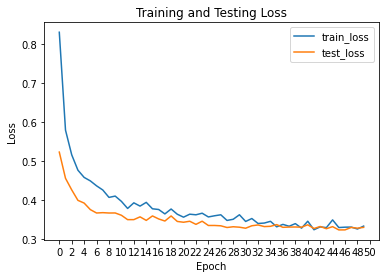

<Figure size 432x288 with 0 Axes>

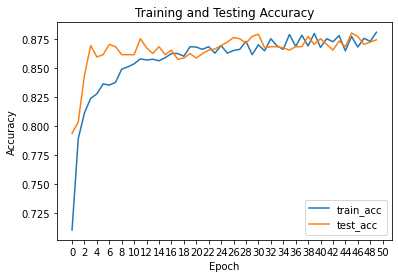

In [ ]:
# Display the performance of the model
plot_history(history)

<Figure size 432x288 with 0 Axes>

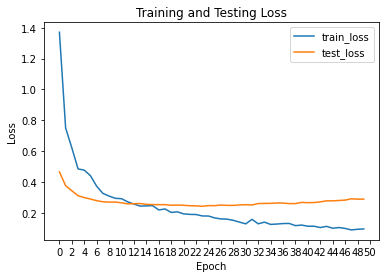

<Figure size 432x288 with 0 Axes>

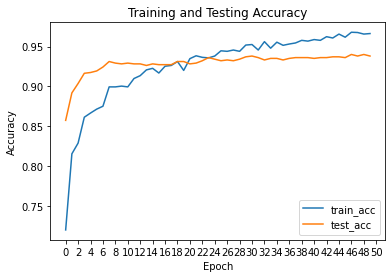

In [ ]:
plot_history(history2)

### Prediction

In [ ]:
# Import OpenCV that can detect human faces in images
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -P face_detection

--2023-03-12 22:54:52--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘face_detection/haarcascade_frontalface_default.xml.1’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2023-03-12 22:54:52 (19.4 MB/s) - ‘face_detection/haarcascade_frontalface_default.xml.1’ saved [930127/930127]



In [ ]:
def predict_image(image_dir, model):
  '''
  Generate original image and image with predictions

  Input: input test image path
  '''
  
  # Import models and create labels for later use
  face_model = cv2.CascadeClassifier('/content/face_detection/haarcascade_frontalface_default.xml')
  mask_label = {0:'mask_incorrectly_worn',1:"with_mask",2:'without_mask'}
  dist_label = {0:(255,255,0),1:(0,255,0),2:(255,0,0)}
  
  # Read images
  base_image = cv2.imread(image_dir)
  img = cv2.cvtColor(base_image, cv2.IMREAD_GRAYSCALE)
  
  # Returns a list of (x,y,w,h) tuples (the information of bound boxes)
  faces = face_model.detectMultiScale(img,scaleFactor=1.2, minNeighbors=1)

  out_img = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

  # Display the original image
  plt.figure(figsize=(20,20))
  plt.subplot(*(1,2,1))
  plt.imshow(out_img)
  plt.xticks([])
  plt.yticks([])
  plt.show
  
  # Make prediction for each face
  for i in range(len(faces)):
    
    (x,y,w,h) = faces[i]
    crop = out_img[y:y+h,x:x+w]
    crop = cv2.resize(crop,(60,60))
    crop = np.reshape(crop,[1,60,60,3])/255.0
    value = round(max(model.predict(crop)[i]),2)
    mask_result = model.predict(crop).argmax()
    result = str(mask_label[mask_result])+' '+str(value)
    cv2.putText(out_img,result,(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[mask_result],1)
    cv2.rectangle(out_img,(x,y),(x+w,y+h),dist_label[mask_result],1)
  
  # Display the image with predictions
  plt.subplot(*(1,2,2))
  plt.imshow(out_img)
  plt.xticks([])
  plt.yticks([])
  plt.show

1/1 [==============================] - 0s 21ms/step


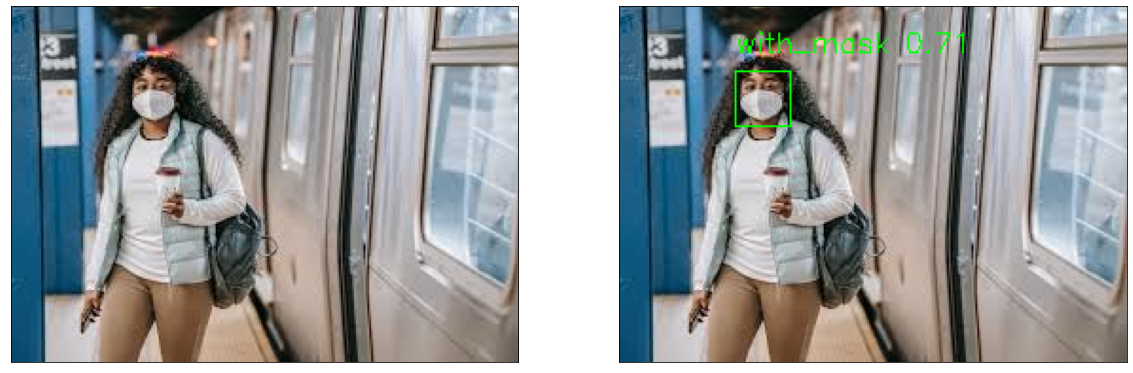

In [ ]:
# Make predictions for VGG
predict_image('/content/Face_mask_dataset/test_img/images.jpg',model)

1/1 [==============================] - 0s 24ms/step


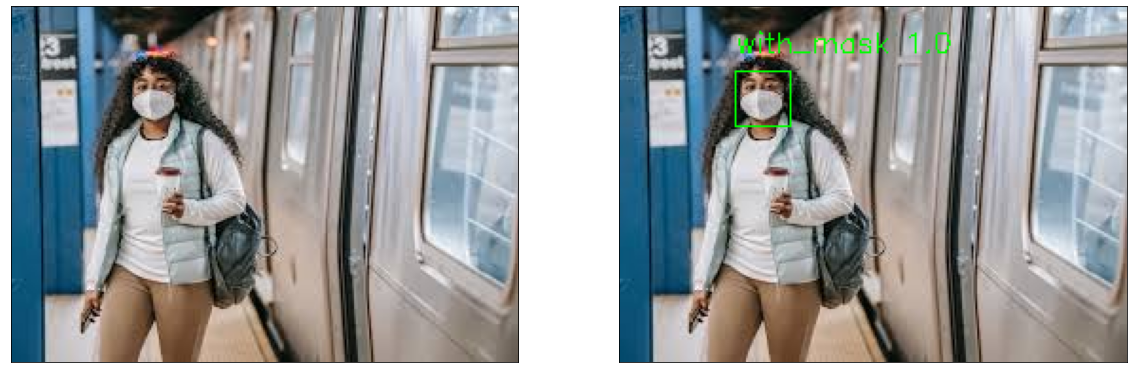

In [ ]:
predict_image('/content/Face_mask_dataset/test_img/images.jpg',model2)

**Note**: The OpenCV face detection tool may fail to detect faces in some cases

## YOLOv8

(**Note**: high GPU RAM is preferred)

### Loading YoloV8


In [ ]:
%pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.5/496.5 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 3.3 MB/s eta 0:00:00


In [ ]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.2/166.8 GB disk)


In [ ]:
# Create a numerical feature for label 
annotations_info_df['class_id'] = annotations_info_df['label'].apply(lambda x: 0 if x =='with_mask' else(1 if x == "mask_incorrectly_worn" else 2))

In [ ]:
# Define training and validation set for YOLO
train, test = train_test_split(annotations_info_df.image_file.unique(), test_size=0.2, random_state=23)

In [ ]:
def pascal_voc_to_yolo_bbox(df_row):
  '''
  Convert bbox format for yolo

  Input: an array of image names and targeted directory
  '''
  x_min, y_min, x_max, y_max, w, h  = df_row['xmin'], df_row['ymin'], df_row['xmax'], df_row['ymax'], df_row['width'], df_row['height']
  
  x_center = ((x_max + x_min) / 2) / w
  y_center = ((y_max + y_min) / 2) / h
  
  width = (x_max - x_min) / w
  height = (y_max - y_min) / h
  
  return [x_center, y_center, width, height]

In [ ]:
# Define image path for training, validation and testing. Note that only training and validation sets will be used during training

image_directory = '/content/Face_mask_dataset/images'

train_path = "/content/Face_mask_dataset/train_img"
test_path = '/content/Face_mask_dataset/test_img'
val_path = "/content/Face_mask_dataset/val_img"

os.mkdir(train_path)
os.mkdir(val_path)

In [ ]:
def copy_image_file(image_items, folder_name):
    '''
    Copy image to seperate train and test folders 

    Input: an array of image names and targeted directory
    '''
    for image in image_items:
            image_path = image_directory + "/" + image
            new_image_path = os.path.join(folder_name, image)
            shutil.copy(image_path, new_image_path)

def create_label_file(image_items, folder_name, df):
    '''
    Create label file for Yolo Training

    Input: an array of image names, targeted directory, and dataframe containing box information
    '''
    for image in image_items:
        fileName = Path(image).stem # extract the file name from the image path
        df_ = df[df['image_file'] == image]
        # Write Yolo readable txt file for each input image
        with open(folder_name + "/" + fileName +'.txt', 'w') as f:
            for i in range(0, len(df_)):
                bbox = pascal_voc_to_yolo_bbox(df_.iloc[i])

                bbox_text = " ".join(map(str, bbox))
                txt = str(df_.iloc[i]['class_id'])+ " " + bbox_text
                f.write(txt)
                if i != len(df_) - 1:
                    f.write("\n")

copy_image_file(train, train_path)
copy_image_file(test, val_path)
create_label_file(train, train_path, annotations_info_df)
create_label_file(test, val_path, annotations_info_df)

In [ ]:
def write_yaml():
  '''
  Create Yaml file for Yolo training 
  '''
  classes = list(annotations_info_df.label.unique())
  class_count = len(classes)
  facemask_yaml = f"""
      train: /content/Face_mask_dataset/train_img
      test: /content/Face_mask_dataset/test_img
      val: /content/Face_mask_dataset/val_img
      nc: {class_count}
      names:
          0 : with_mask
          1 : mask_weared_incorrect
          2 : without_mask
      """

  with open('facemask.yaml', 'w') as f:
      f.write(facemask_yaml)
    
  %cat facemask.yaml

write_yaml()


      train: /content/Face_mask_dataset/train_img
      test: /content/Face_mask_dataset/test_img
      val: /content/Face_mask_dataset/val_img
      nc: 3
      names:
          0 : with_mask
          1 : mask_weared_incorrect
          2 : without_mask
      

### Training

In [ ]:
# Due to some unexpected reasons colab is unable to save local 
model3 = YOLO("yolov8n.pt") 
model3.train(data="facemask.yaml", epochs=50)

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=facemask.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opse

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

### Evaluation

In [ ]:
model3.val(data="facemask.yaml")

Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/Face_mask_dataset/val_img.cache... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.27it/s]
                   all        171        721      0.822      0.763      0.816      0.575
             with_mask        171        544       0.94       0.93       0.96       0.69
 mask_weared_incorrect        171         27      0.685      0.593      0.638      0.476
          without_mask        171        150       0.84      0.768       0.85       0.56
Speed: 1.5ms preprocess, 6.7ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/val


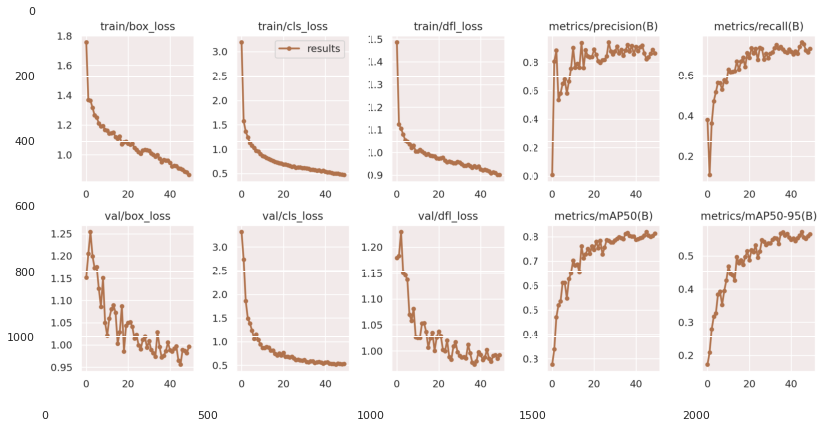

In [ ]:
# Check plots 
results = "/content/runs/detect/train/results.png"
results = cv2.imread(results)
plt.figure(figsize=(14, 10))
plt.imshow(results)

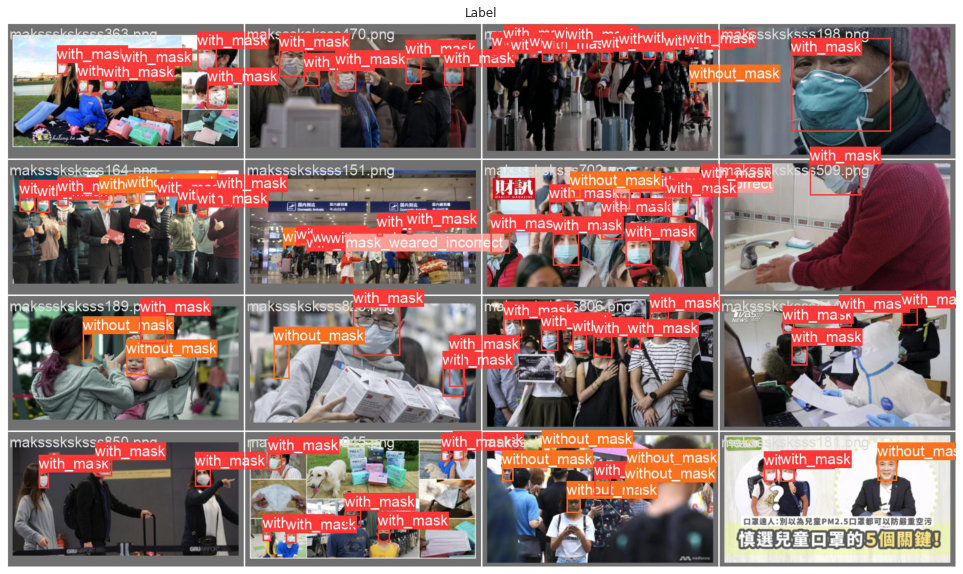

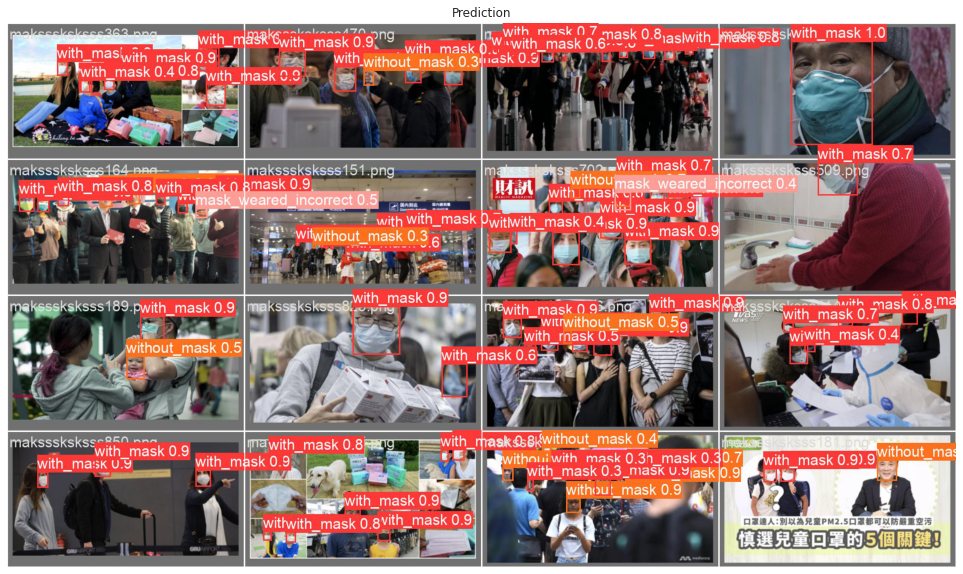

In [ ]:
val_label = Image.open("/content/runs/detect/train/val_batch0_labels.jpg")
val_pred = Image.open("/content/runs/detect/train/val_batch0_pred.jpg")

plt.figure(figsize=(20,10))
plt.imshow(val_label)
plt.title("Label")
plt.axis(False)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(val_pred)
plt.title("Prediction")
plt.axis(False)
plt.show()

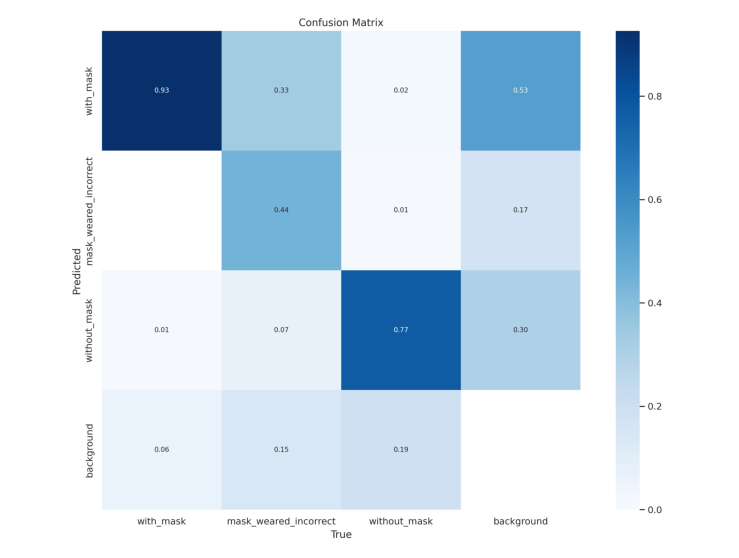

In [ ]:
from PIL import Image
confusion_matrix = Image.open("/content/runs/detect/val/confusion_matrix.png")
plt.figure(figsize=(20,10))
plt.imshow(confusion_matrix)
plt.axis(False)
plt.show()

Accuracy can be calculated as the sum of TP of three classes times number of labels. 

### Prediction

In [ ]:
model3 = YOLO(model="/content/runs/detect/train/weights/best.pt")

In [ ]:
predict_path = "/content/runs/detect/predict/"

def get_predicted(i):
  '''
  Get the prediction of i-th image in test set.
  '''
  filenames = glob.glob(test_path+"/*.jpg", recursive=False)
  test_image1 = cv2.imread(filenames[i-1])

  results = model3.predict([test_image1], save=True, line_thickness=1)

  filenames_ = glob.glob(predict_path+"/*.jpg", recursive=False)
  predicted_image = Image.open(filenames_[0])
  plt.figure(figsize=(10,10))
  plt.imshow(predicted_image)
  plt.title("Prediction")
  plt.axis(False)
  plt.show()




0: 480x640 1 with_mask, 41.3ms
Speed: 0.7ms preprocess, 41.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


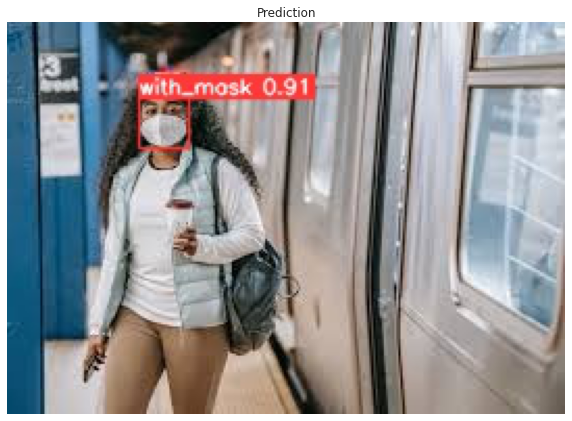

In [ ]:
get_predicted(1)

## YOLOv5

### Import YOLO V5

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
# Collecting model information
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15291, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 15291 (delta 0), reused 1 (delta 0), pack-reused 15287
Receiving objects: 100% (15291/15291), 14.19 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (10483/10483), done.


In [ ]:
# Loading required packages
!cd yolov5 && pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.6.0 which is incompatible.


In [ ]:
import torch
modelV5 = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True)

/usr/local/lib/python3.9/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirement "setuptools>=65.5.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/u

  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
# Creating yaml file for YOLOV5
def write_yaml_v5():
  '''
  Create Yaml file for Yolo training 
  '''
  classes = list(annotations_info_df.label.unique())
  class_count = len(classes)
  facemaskV5_yaml = f"""
      train: /content/Face_mask_dataset/train_img
      test: /content/Face_mask_dataset/test_img
      val: /content/Face_mask_dataset/val_img
      nc: {class_count}
      names:
          0 : with_mask
          1 : mask_weared_incorrect
          2 : without_mask
      """

  with open('facemaskV5.yaml', 'w') as f:
      f.write(facemaskV5_yaml)
    
  %cat facemaskV5.yaml

write_yaml_v5()
!cp "/content/facemaskV5.yaml" "/content/yolov5"


      train: /content/Face_mask_dataset/train_img
      test: /content/Face_mask_dataset/test_img
      val: /content/Face_mask_dataset/val_img
      nc: 3
      names:
          0 : with_mask
          1 : mask_weared_incorrect
          2 : without_mask
      

### Training model

In [ ]:
!cd yolov5 && python train.py --img 640 --batch 16 --epochs 50 --data facemaskV5.yaml --weights yolov5s.pt --workers 2

train: weights=yolov5s.pt, cfg=, data=facemaskV5.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-117-g85f6019 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0

### Model evaluation

In [ ]:
modelV5 = torch.hub.load("ultralytics/yolov5", "custom", path="/content/yolov5/runs/train/exp/weights/best.pt", force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirement "setuptools>=65.5.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2023-3-9 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


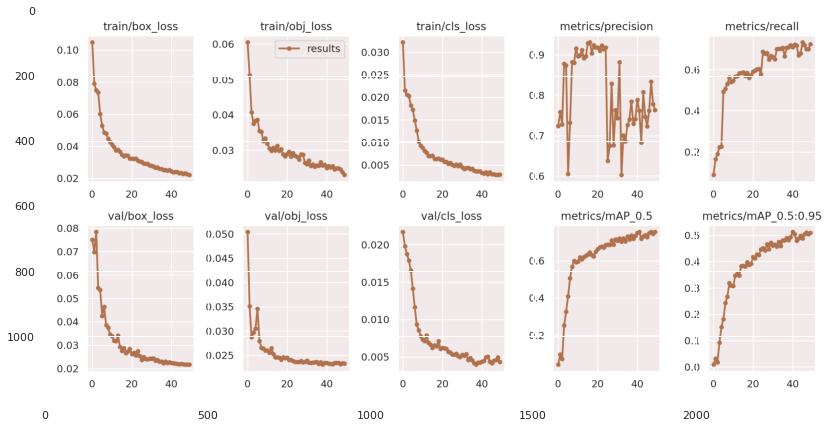

In [ ]:
# Check plots 
results = "/content/yolov5/runs/train/exp/results.png"
results = cv2.imread(results)
plt.figure(figsize=(14, 10))
plt.imshow(results)

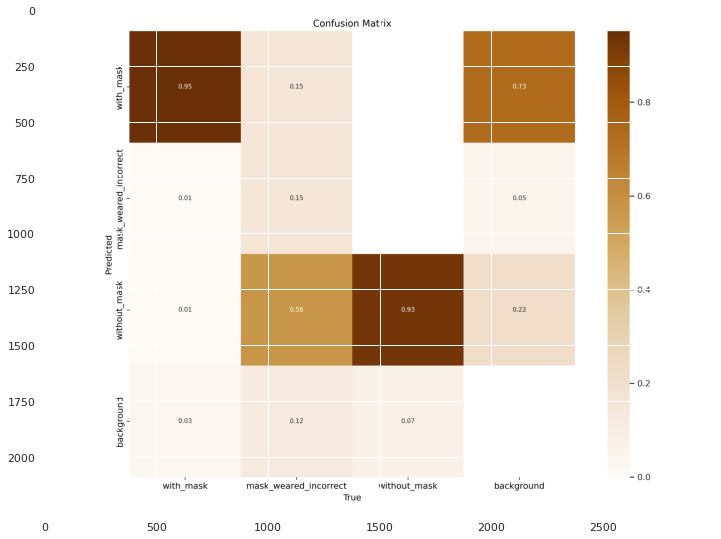

In [ ]:
# Confusion matrix
conf_mat = "/content/yolov5/runs/train/exp/confusion_matrix.png"
conf_mat = cv2.imread(conf_mat)
plt.figure(figsize=(12, 10))
plt.imshow(conf_mat)

### Predictions

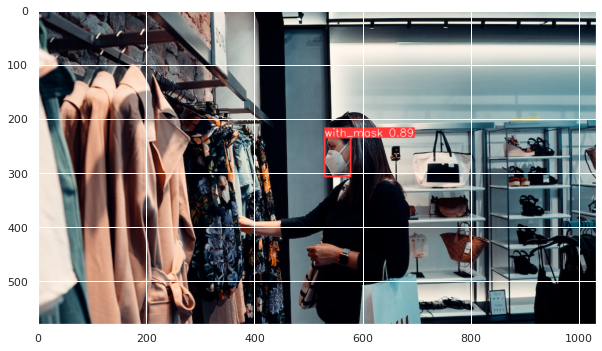

In [ ]:
# Try YOLOv5 on a few graphs from the internet
sample1 = "https://images.unsplash.com/photo-1591085686350-798c0f9faa7f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1031&q=80"
result = modelV5(sample1)

plt.figure(figsize=(10,8))
plt.imshow(np.squeeze(result.render()))
plt.show()

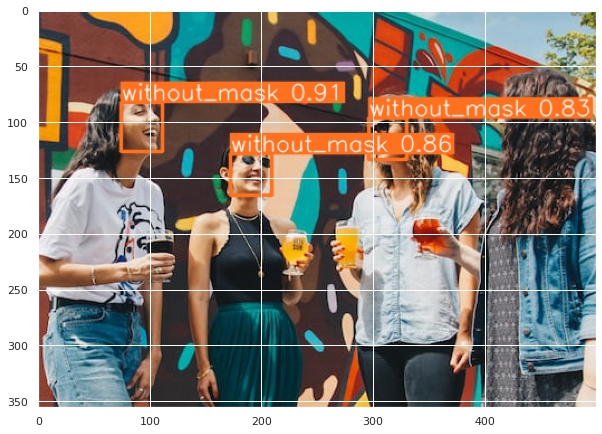

In [ ]:
sample2 = "https://images.unsplash.com/photo-1532635241-17e820acc59f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MTR8fHBlb3BsZXxlbnwwfHwwfHw%3D&auto=format&fit=crop&w=500&q=60"
result = modelV5(sample2)

plt.figure(figsize=(10,8))
plt.imshow(np.squeeze(result.render()))
plt.show()

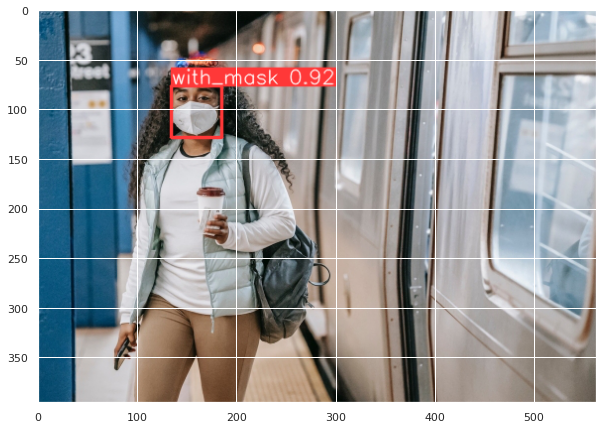

In [ ]:
sample3 = "https://newsroom.unsw.edu.au/sites/default/files/styles/full_width__2x/public/thumbnails/image/a_woman_leaves_a_commuter_train_wearing_a_face_mask_1.jpeg?itok=N_zfgg6i"
result = modelV5(sample3)

plt.figure(figsize=(10,8))
plt.imshow(np.squeeze(result.render()))
plt.show()

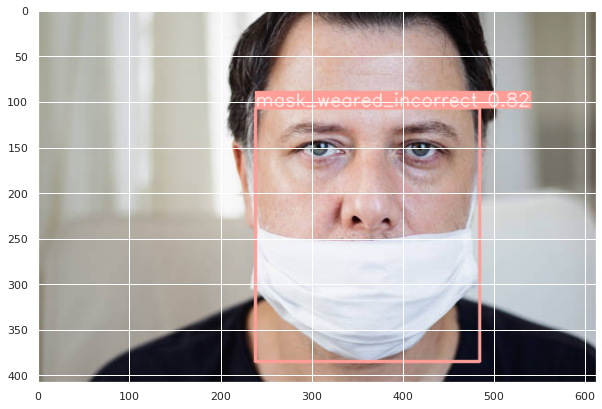

In [ ]:
sample4 = "https://media.istockphoto.com/id/1250449628/photo/portrait-of-middle-aged-man-wearing-his-mask-incorrectly.jpg?s=612x612&w=0&k=20&c=WsVPuUp4gvC4PgTFJioIL6Z8zEvImpuOmFFcxp8eWiI="
result = modelV5(sample4)

plt.figure(figsize=(10,10))
plt.imshow(np.squeeze(result.render()))
plt.show()

# Demo codes for real time detection (run locally, eg. Jupyter)

## Demo for Yolo V8, first download best.pt for V8

In [ ]:
# modelV8 = YOLO("/Users/dongxinghao/bestV8.pt")

In [ ]:
# modelV8.predict(source="0", show=True)

## Demo for v5

In [ ]:
# modelV5 = torch.hub.load("ultralytics/yolov5", "custom", path="/Users/dongxinghao/bestV5.pt", force_reload=True)

In [ ]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#    ret, frame = cap.read()
#    results = modelV5(frame)
#    cv2.imshow('Object Detection', np.squeeze(results.render()))

#    if cv2.waitKey(10) & 0xFF == ord('q'):
#        break
# cap.release()
# cv2.destroyAllWindows()